# Quantization
Quantization focuses on representing data with fewer bits while also trying to preserve the precision of the original data. This often means converting a data type to represent the same information with fewer bits. For example, if your model weights are stored as 32-bit floating points and they’re quantized to 16-bit floating points, this halves the model size which makes it easier to store and reduces memory usage. Lower precision can also speedup inference because it takes less time to perform calculations with fewer bits.
https://huggingface.co/docs/diffusers/en/quantization/overview

In [1]:
import numpy as np
import torch
from pathlib import Path
from diffusers.utils import load_image
from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
from diffusers import StableDiffusionPipeline,DDIMScheduler

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def print_gpu_memory():
    allocated = torch.cuda.memory_allocated() / 1024**2
    reserved = torch.cuda.memory_reserved() / 1024**2
    peak = torch.cuda.max_memory_allocated() / 1024**2

    print(f"Current allocated: {allocated:.2f} MB")
    print(f"Current reserved : {reserved:.2f} MB")
    print(f"Peak allocated   : {peak:.2f} MB")

In [3]:
model_id = 'stable-diffusion-v1-5/stable-diffusion-v1-5'
pipeline = StableDiffusionPipeline.from_pretrained(model_id,
                                                    safety_checker=None, 
                                                    torch_dtype=torch.float16).to(device)

pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [4]:
pipeline.unet.get_memory_footprint()/1024**3

1.600982554256916

  0%|          | 0/35 [00:00<?, ?it/s]

Current allocated: 2065.73 MB
Current reserved : 3252.00 MB
Peak allocated   : 2676.32 MB


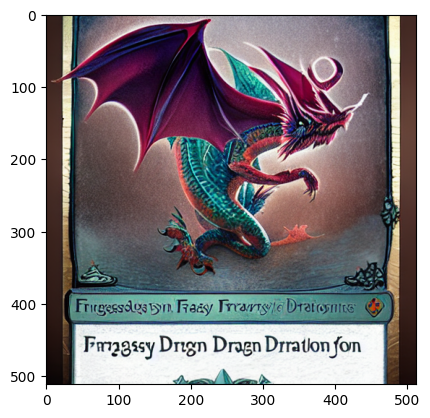

In [4]:
prompt = "Fantasy dragon"

torch.cuda.reset_peak_memory_stats()

gen_image = pipeline(
                    prompt=prompt,
                    guidance_scale=7.5,
                    num_inference_steps=35,
                    height=512,
                    width=512,
                    generator=torch.manual_seed(42)
                ).images[0]

print_gpu_memory()
plt.imshow(gen_image)
plt.show()
    



In [ ]:
pipeline.to('cpu')
torch.cuda.empty_cache()
del pipeline

# Load in 4 bit format

In [3]:
from diffusers import BitsAndBytesConfig as DiffusersBitsAndBytesConfig
from diffusers import UNet2DConditionModel

In [5]:
quant_config = DiffusersBitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16,
                                         bnb_4bit_use_double_quant=True,
                                         bnb_4bit_quant_type="nf4"
                                           )

model_id = 'stable-diffusion-v1-5/stable-diffusion-v1-5'
unet = UNet2DConditionModel.from_pretrained(model_id, 
                                            subfolder="unet", 
                                            torch_dtype=torch.float16, 
                                            quantization_config=quant_config)

pipeline = StableDiffusionPipeline.from_pretrained(model_id,
                                                    unet=unet,
                                                    safety_checker=None, 
                                                    torch_dtype=torch.float16).to(device)

pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [9]:
pipeline.unet.get_memory_footprint()/1024**3

1.2237280681729317

In [10]:
for name,param in pipeline.unet.named_parameters():
    print(name,param.dtype)

conv_in.weight torch.float16
conv_in.bias torch.float16
time_embedding.linear_1.weight torch.uint8
time_embedding.linear_1.bias torch.float16
time_embedding.linear_2.weight torch.uint8
time_embedding.linear_2.bias torch.float16
down_blocks.0.attentions.0.norm.weight torch.float16
down_blocks.0.attentions.0.norm.bias torch.float16
down_blocks.0.attentions.0.proj_in.weight torch.float16
down_blocks.0.attentions.0.proj_in.bias torch.float16
down_blocks.0.attentions.0.transformer_blocks.0.norm1.weight torch.float16
down_blocks.0.attentions.0.transformer_blocks.0.norm1.bias torch.float16
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.weight torch.uint8
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.weight torch.uint8
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.weight torch.uint8
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0.weight torch.uint8
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0.bias torch.float16
down_blocks.

  0%|          | 0/35 [00:00<?, ?it/s]

Current allocated: 1688.00 MB
Current reserved : 2834.00 MB
Peak allocated   : 2298.59 MB


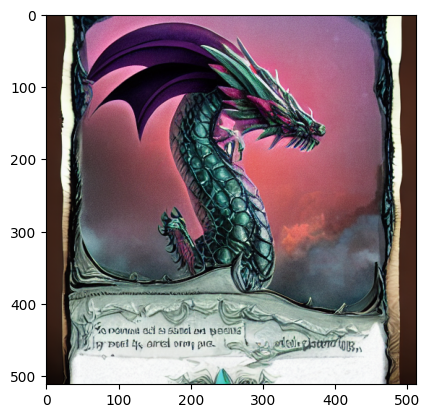

In [8]:
prompt = "Fantasy dragon"

torch.cuda.reset_peak_memory_stats()

gen_image = pipeline(
                    prompt=prompt,
                    guidance_scale=7.5,
                    num_inference_steps=35,
                    height=512,
                    width=512,
                    generator=torch.manual_seed(42)
                ).images[0]

print_gpu_memory()
plt.imshow(gen_image)
plt.show()
    